# Segmentación de clientes en Python
En este artículo se hace un análisis de segmentación de clientes de un retail online de UK. La base de datos registra transacciones ocurridas entre el 01/12/2010 y 10/12/2011. Fue utilizada por primera vez en el artículo:

*Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).*

La base de datos se puede descargar en el siguiente sitio web:
https://archive.ics.uci.edu/ml/datasets/Online%20Retail

A continuación se cargan los paquetes a utilizar en el análisis y se ajustan algunos formatos para los resultados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.set_option('display.float_format', lambda x: '%.2f' % x) # formato del output, 2 decimales
pd.set_option('display.max_columns', 100) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 100) # número máximo de filas a mostrar en el terminal

Luego se cargan los datos y se hacen algunos análisis iniciales. Inicialmente la base de datos tiene 406.829 observaciones (filas) y 8 variables (columnas). Se eliminan los datos con missing values y se corrige el formato para la fecha. Se registran 3.896  transacciones diferentes.

In [3]:
data = pd.read_csv('C:/Users/acuna/Dropbox/Consultora/EDA SPA/Analisis&BBDD/Customer segmentation/Online Retail.csv',
                   parse_dates=True)
data = data.dropna()
print('Data shape: \n', data.shape)
print('Variables: \n', data.info())
print('Primeras 5 observaciones: \n', data.head())
print('Número de transacciones: \n', data['Description'].unique().shape)

Data shape: 
 (406829, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB
Variables: 
 None
Primeras 5 observaciones: 
   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION 

Al describir los datos, se observa que existen observaciones con cantidades negativas o con precio unitario igual a cero. Se opta por eliminar estas observaciones de la base de datos.

In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print(data.describe())
data = data.drop(data[data['Quantity'] < 0].index)
data = data.drop(data[data['UnitPrice'] == 0].index)

       Quantity  UnitPrice  CustomerID
count 406829.00  406829.00   406829.00
mean      12.06       3.46    15287.69
std      248.69      69.32     1713.60
min   -80995.00       0.00    12346.00
25%        2.00       1.25    13953.00
50%        5.00       1.95    15152.00
75%       12.00       3.75    16791.00
max    80995.00   38970.00    18287.00


## Análisis de cohortes
El primer estudio a realizar es un **análisis de cohortes**. En primer lugar se crea una función que determina el mes (y año) en que se realizó una transacción. Esta función usa como argumento la fecha de facturación, y entrega el mes de facturación como output. Luego se agrupan los datos por CustomerID, y se determina la fecha más antigua en que cada cliente realizó una transacción con el retail online. Esta variable se añade a la base de datos ('CohortMonth' o mes de la cohorte).

In [5]:
# Function that parses the date
def get_month(x): 
    return dt.datetime(x.year, x.month, 1) 

# Crear columna InvoiceMonth
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month) 

# Agrupar por CustomerID y seleccionar la columna InvoiceMonth
bycust = data.groupby('CustomerID')['InvoiceMonth'] 

# Añadir el valor mínimo de InvoiceDay a los datos (Fecha de la primera compra
data['CohortMonth'] = bycust.transform('min')
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceMonth  \
0 2010-01-12 08:26:00       2.55    17850.00  United Kingdom   2010-01-01   
1 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   
2 2010-01-12 08:26:00       2.75    17850.00  United Kingdom   2010-01-01   
3 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   
4 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   

  CohortMonth  
0  2010-01-01  
1  2010-01-01  
2  2010-01-01  
3  2010-01-01  
4  2010-01-01  


Luego se define una función, que toma como argumento una fecha y entrega el año, mes y día. Esta función se aplica tanto a la fecha de facturación como a la fecha de la cohorte (primera transacción de cada cliente). Luego se calculan las diferencias en años y meses, y se usan estas diferencias para estimar cuánto tiempo en meses ha pasado desde la primera transacción. Esta variable se agrega a la base de datos como 'CohortIndex'.

In [6]:
# Calcular time offset en días
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Obtener los números enteros que corresponden a los años, meses y días de la columna 'InvoiceDay'
invoice_year, invoice_month, invoice_day = get_date_int(data, 'InvoiceMonth')

# Obtener los números enteros que corresponden a los años, meses y días de la columna 'CohortDay'
cohort_year, cohort_month, cohort_day = get_date_int(data, 'CohortMonth')

# Calcular la diferencia en años
years_diff = invoice_year - cohort_year

# Calcular la diferencia en meses
months_diff = invoice_month - cohort_month

# Calcular la diferencia en días a partir de los valores anteriores
data['CohortIndex'] = years_diff * 12 + months_diff + 1
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceMonth  \
0 2010-01-12 08:26:00       2.55    17850.00  United Kingdom   2010-01-01   
1 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   
2 2010-01-12 08:26:00       2.75    17850.00  United Kingdom   2010-01-01   
3 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   
4 2010-01-12 08:26:00       3.39    17850.00  United Kingdom   2010-01-01   

  CohortMonth  CohortIndex  
0  2010-01-01            1  
1  2010-01-01            1  
2  2010-01-01    

A continuación se agrupan los datos por CohortMonth y CohortIndex, y se cuenta el número de clientes distintos en cada grupo. Después se genera una pivot table, en que el índice es la fecha de la cohorte, CohortMonth, las columnas están dadas por CohortIndex (meses desde la primera compra), y en los valores va el número de clientes (calculado anteriormente). Para obtener la **tasa de retención de clientes** se dividen los valores de la tabla por los valores iniciales (cohorte completa). Finalmente se grafica.

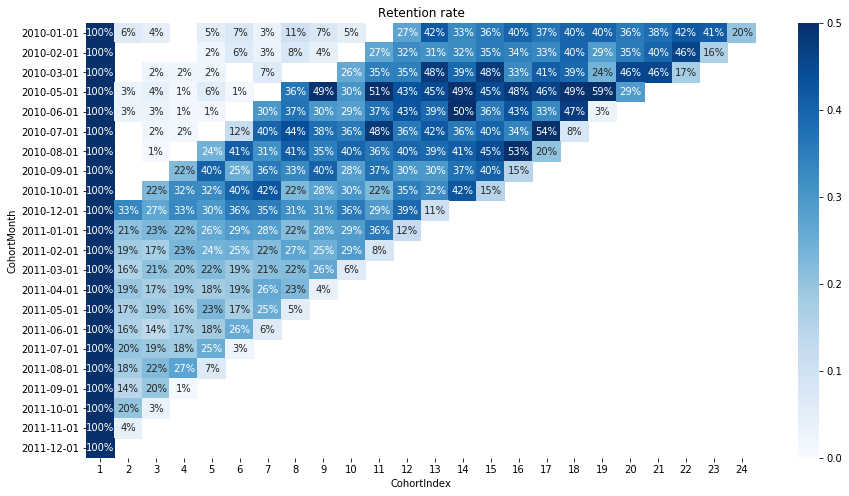

In [14]:
# Calcular tasa de retención
# Crear un objeto groupby usando 'CohortMonth' y 'CohortIndex'
grouping = data.groupby(['CohortMonth', 'CohortIndex'])

# Contar el número de valores únicos por 'CustomerID'
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date.astype('O')
 
# Crear una pivot table
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
# print(cohort_counts)

# Seleccionar la primera columna y guardarla como cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Dividir el conteo de la cohorte por el tamaño, por filas
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Tabla con la tasa de retención por cohorte
# print(retention.round(3)*100)

# Visualizar retention rate
plt.figure(figsize=(15,8))
plt.title('Retention rate')
sns.heatmap(data=retention, 
            annot=True, 
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap='Blues')
plt.show()

El análisis se repite pero centrado en la **cantidad promedio** de productos adquiridos por los clientes de cada cohorte.

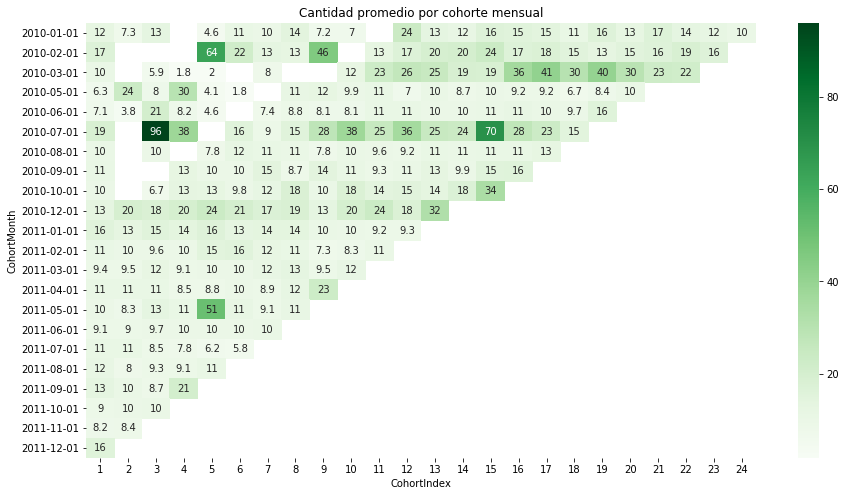

In [20]:
# Calcular cantidad promedio
# Crear un objeto groupby usando 'CohortMonth' y 'CohortIndex'
grouping = data.groupby(['CohortMonth', 'CohortIndex']) 

# Calcular el promedio de la columna 'UnitPrice'
cohort_data = grouping['Quantity'].mean()

# Resetear el index de cohort_data
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date.astype('O')

# Crear una pivot table
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
# print(average_quantity.round(1))

# Visualizar average quantity metric
plt.figure(figsize=(15,8))
plt.title('Cantidad promedio por cohorte mensual')
sns.heatmap(data=average_quantity, 
            annot=True, 
            cmap='Greens')
plt.show()

Por último, se calcula el **precio promedio** pagado por los clientes de cada cohorte.

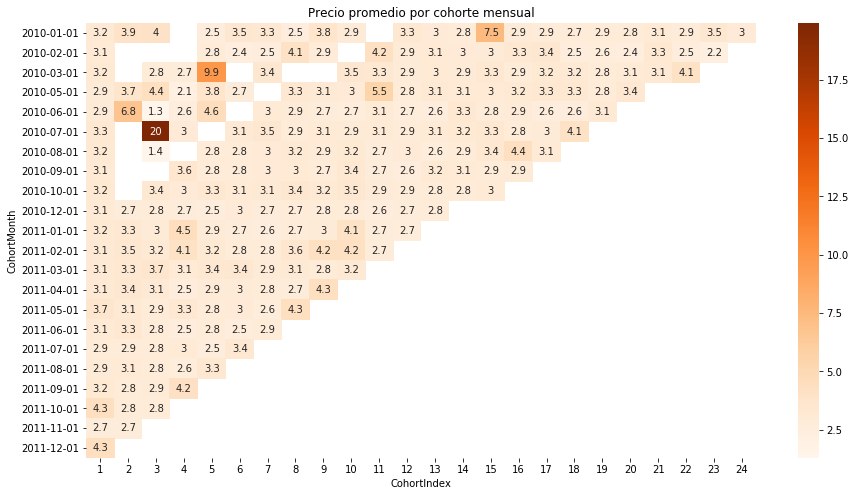

In [22]:
# Calcular el precio promedio
# Crear un objeto groupby usando 'CohortMonth' y 'CohortIndex'
grouping = data.groupby(['CohortMonth', 'CohortIndex']) 

# Calcular el promedio de la columna 'UnitPrice'
cohort_data = grouping['UnitPrice'].mean()

# Resetear el index de cohort_data
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date.astype('O')

# Crear una pivot table
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
# print(average_price.round(1))

# Visualizar average price metric
plt.figure(figsize=(15,8))
plt.title('Precio promedio por cohorte mensual')
sns.heatmap(data=average_price, 
            annot=True, 
            cmap='Oranges')
plt.show()

## Recency, Frequency and Monetary Value analysis
El segundo estudio es un análisis RFM, centrado en tres indicadores que permiten estimar  el valor de los clientes:
- **Recency**. ¿Qué tan recientemente compró un cliente por última vez?
- **Frequency**. ¿Qué tan seguido compra un cliente?
- **Monetary Value**. ¿Cuánto ha gastado un cliente en compras?

El primer paso es definir un "snapshot date", es decir, la fecha de referencia en la cual se supone que se hace el análisis. Se define como una fecha igual a la más reciente encontrada en la base de datos más un día. La fecha más reciente en la base de datos es 2011-12-10 (%y-%m-%d), por lo que la snapshot date es 2011-12-11. 

Además se calcula el costo total pagado por cada producto en cada transacción, TotalSum, igual a la cantidad por el precio unitario.

In [24]:
# Definir una snapshot_date
print('Min:{}; Max:{}'.format(min(data['InvoiceDate']),
                              max(data['InvoiceDate'])))
snapshot_date = max(data['InvoiceDate']) + dt.timedelta(days=1)

# Agregar columna TotalSum
data['TotalSum'] = data['Quantity'] * data['UnitPrice']
print(data.describe())

Min:2010-01-12 08:26:00; Max:2011-12-10 17:19:00
       Quantity  UnitPrice  CustomerID  CohortIndex  TotalSum
count 397884.00  397884.00   397884.00    397884.00 397884.00
mean      12.99       3.12    15294.42         7.29     22.40
std      179.33      22.10     1713.14         6.12    309.07
min        1.00       0.00    12346.00         1.00      0.00
25%        2.00       1.25    13969.00         1.00      4.68
50%        6.00       1.95    15159.00         6.00     11.80
75%       12.00       3.75    16795.00        11.00     19.80
max    80995.00    8142.75    18287.00        24.00 168469.60


Luego se calculan los indicadores RFM. Se agrupa por cliente y se calculan los indicadores **Recency** (días entre el snapshot day y el último día en que compró cada cliente), **Frequency** (número de veces que compró cada cliente), y **Monetary Value** (suma total gastada por cada cliente).

In [25]:
# Calcular Recency, Frequency and Monetary value para cada cliente
datamart = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Renombrar las columnas
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)
print(datamart.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.00        327          1       77183.60
12347.00         41        182        4310.00
12348.00         77         31        1797.24
12349.00         20         73        1757.55
12350.00        312         17         334.40


A continuación los indicadores se segmentan usando percentiles, 4 grupos iguales para cada variable. Se crean nuevas variables que indican el percentil al que corresponde cada indicador de cada cliente, y luego estos valores se suman para obtener el **RFM Score**. Mientras mayor sea este indicador, mayor es el valor de dicho cliente para la empresa.

In [27]:
 # Calculate 4 groups for Recency, Frequency and Monetary Value
# Crear labels
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Asignar labels a cada grupo creado en base a percentiles
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(datamart['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

# Crear nuevas columnas R, F  y M
datamart = datamart.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)
print(datamart.head())

# Calcular RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart.head())

            Recency  Frequency  MonetaryValue  R  F  M
CustomerID                                            
12346.00        327          1       77183.60  1  1  4
12347.00         41        182        4310.00  3  4  4
12348.00         77         31        1797.24  2  2  4
12349.00         20         73        1757.55  4  3  4
12350.00        312         17         334.40  1  1  2
            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score
CustomerID                                                       
12346.00        327          1       77183.60  1  1  4       6.00
12347.00         41        182        4310.00  3  4  4      11.00
12348.00         77         31        1797.24  2  2  4       8.00
12349.00         20         73        1757.55  4  3  4      11.00
12350.00        312         17         334.40  1  1  2       4.00


Finalmente se definen segmentos arbitrarios en base al RFM Score, según la regla mostrada en la siguiente celda.

In [28]:
# RFM table
# Definir segmentos arbitrariamente
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Crear variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)
print(datamart.head())

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12346.00        327          1       77183.60  1  1  4       6.00    Middle
12347.00         41        182        4310.00  3  4  4      11.00       Top
12348.00         77         31        1797.24  2  2  4       8.00    Middle
12349.00         20         73        1757.55  4  3  4      11.00       Top
12350.00        312         17         334.40  1  1  2       4.00       Low


Se agrupa por RFM level y se obtienen los valores promedio para los 3 indicadores. Además, se calcula el tamaño de cada segmento. Se observa que el segmento Top agrupa los clientes que en promedio han comprado más recientemente, con mayor frecuencia, y que han gastado más en la empresa. No obstante, hay que mencionar que por la construcción de los segmentos se esperaba encontrar este resultado.

In [29]:
# Analizar segmentos arbitrarios
# Calculo de promedios para cada RFM_level, y el tamaño de cada segmento
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
    }).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low        212.60     15.40        264.60  1274
Middle      87.30     50.00       1087.70  1795
Top         27.00    227.30       5218.20  1269


Una forma de construir segmentos menos arbitrarios, es usar un algoritmo de clustering, como **KMeans**, aunque antes se deben preprocesar las variables, que deben estar normalizadas y tener distribuciones simétricas para garantizar el buen funcionamiento del algoritmo. 

En la descripción de las variables se observa que las variables tienen medias y desviaciones estándar distintas. Además, todas tienen un sesgo hacia la derecha, lo que se observa en los gráficos, y al comprobar que la mediana es menor a la media de los datos.

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Recency        4338 non-null   int64   
 1   Frequency      4338 non-null   int64   
 2   MonetaryValue  4338 non-null   float64 
 3   R              4338 non-null   category
 4   F              4338 non-null   category
 5   M              4338 non-null   category
 6   RFM_Score      4338 non-null   float64 
 7   RFM_Level      4338 non-null   object  
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 376.4+ KB
None
       Recency  Frequency  MonetaryValue  RFM_Score
count  4338.00    4338.00        4338.00    4338.00
mean    106.47      91.72        2054.27       7.51
std     115.08     228.79        8989.23       2.79
min       1.00       1.00           3.75       3.00
25%      23.00      17.00         307.41       5.00
50%      62.00      41.00         674.4

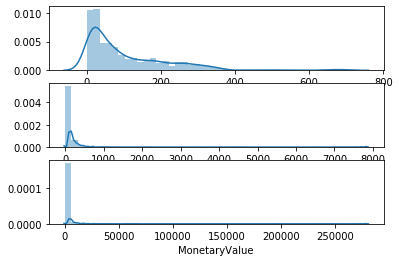

In [30]:
# Análisis descriptivo de los datos
print(datamart.info())
# datamart[['Recency', 'Frequency']] = datamart[['Recency', 'Frequency']].astype(float)
print(datamart.describe())

# Plot distributions
plt.subplot(3, 1, 1)
sns.distplot(datamart['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(datamart['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(datamart['MonetaryValue'])
plt.show()

Para solucionar el problema anterior primero se aplica logaritmo natural a los datos, lo que permite hacer que la distribución de las variables sea menos asimétrica. Luego se normalizan. En los gráficos se muestra el resultado.

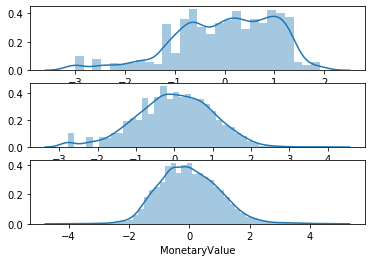

In [31]:
# Log-normalizar los datos
datamart_log = np.log(datamart[['Recency', 'Frequency', 'MonetaryValue']])

# Normalizar
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_norm = scaler.transform(datamart_log)

# Crear un pandas DataFrame
datamart_norm = pd.DataFrame(data=datamart_norm, index=datamart_log.index, columns=datamart_log.columns)

# Plot distributions
plt.subplot(3, 1, 1)
sns.distplot(datamart_norm['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(datamart_norm['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(datamart_norm['MonetaryValue'])
plt.show()

Luego se debe determinar el número óptimo de clústeres mediante el **elbow method**. Según este método, el número de clústeres óptimos es aquel a partir del cual se observa un rendimiento decreciente en la disminución de la inercia del modelo cuando se añaden clústeres adicionales. En este caso no está muy claro cuál es el número óptimo de clústeres, ya que podría ser una cantidad entre 2 y 4. Se opta por modelar 3 clústeres, para analizar cómo difieren los indicadores RFM de estos segmentos en comparación a los segmentos arbitrarios definidos anteriormente.

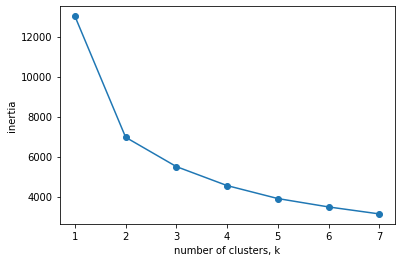

In [32]:
# Seleccionar número de clústers para KMeans
ks = range(1, 8)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(datamart_norm)
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Se calculan los clústeres con el algoritmo de KMeans, con un número de clústeres igual a 3. Luego se obtienen los indicadores RFM promedio según clúster. El segmento 0 es el más valioso, ya que es el que tiene menor Recency, mayor Frequency y mayor Monetary Value. Luego vendría el grupo 2 y finalmente el 1.

In [38]:
# KMeans de 3 clústers
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(datamart_norm)
datamart['cluster_labels'] = kmeans.predict(datamart_norm)

# Analizar los segmentos
grouped = datamart.groupby(['cluster_labels'])

# Calcular los valores RFMT promedio y los tamaños de segmento de cada clúster
table =grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
    }).round(1)
print(table)

               Recency Frequency MonetaryValue      
                  mean      mean          mean count
cluster_labels                                      
0                20.30    250.60       6243.10  1038
1               191.90     14.90        290.10  1488
2                85.70     63.80       1103.40  1812


Para visualizar los resultados se puede usar un **snake plot**. Se usan los datos normalizados para que las variables se ubiquen en la misma escala de valores. Primero se transforma la base de datos a un formato long, usando la función melt de pandas. Luego se visualizan los datos. Se observa que el grupo 0 tiene indicadores de Frequency y Monetary Value altos, y una baja Recency, mientras que el grupo 1 es todo lo contrario. Por su parte, el grupo 2 se ubica en un rango intermedio.

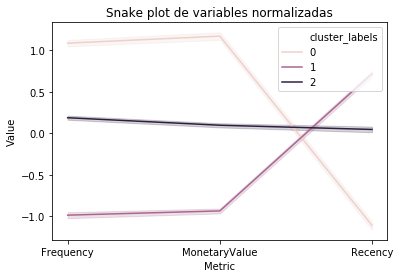

In [39]:
# Preparar los datos para snake plot
datamart_norm['cluster_labels'] = kmeans.predict(datamart_norm)

# Aplicar melt (long format) a los datos normalizados y resetear el index
datamart_melt = pd.melt(datamart_norm.reset_index(),                         
# CustomerID y Cluster serán ID variables
                    id_vars=['CustomerID', 'cluster_labels'],
# RFM values serán value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],                 
# Nomrbar la variable y sus valores
                    var_name='Metric', value_name='Value'
					)

# Visualizar el snake plot
plt.title('Snake plot de variables normalizadas')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='cluster_labels')
plt.show()

Por último, se calcula la importancia relativa de cada variable, en relación a los indicadores poblacionales (sin agrupar por clúster). El indicador calculado muestra en qué porcentaje el indicador RFM de cada clúster es mayor o menor que el indicador poblacional. Luego, se grafican los resultados en un **heatmap**. El análisis es similar al del gráfico anterior. El segmento 0 tiene una Recency menor al promedio en un 81%, una Frecuencia un 173% mayor, y un Monetary Value un 204% mayor que el promedio.

                Recency  Frequency  MonetaryValue
cluster_labels                                   
0                 -0.81       1.73           2.04
1                  0.80      -0.84          -0.86
2                 -0.20      -0.30          -0.46


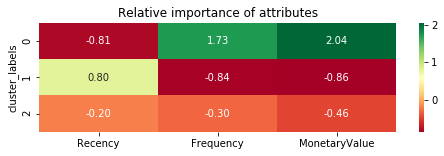

In [40]:
# Calcular la importancia relativa de cada variable
datamartRFM = datamart[['Recency', 'Frequency', 'MonetaryValue','cluster_labels']]
cluster_avg = datamartRFM.groupby(['cluster_labels']).mean() 

# Calcular RFM promedio para el total de clientes
population_avg = datamart[['Recency', 'Frequency', 'MonetaryValue']].mean()

# Calcular la importancia relativa de las variables en relación a la población
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))


# Plot relative importance heatmap
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()